In [1]:
!gdown --id 1Mwf7W5sgcTL3zEP8Rm3xdfYfLQBZP6Cy

Downloading...
From: https://drive.google.com/uc?id=1Mwf7W5sgcTL3zEP8Rm3xdfYfLQBZP6Cy
To: /content/jena_climate_2009_2016.csv
42.0MB [00:00, 90.1MB/s]


In [2]:
#install Required Libs
!pip install -q -U keras-tuner
!pip install fbprophet
!pip install statsmodels --upgrade

     |████████████████████████████████| 97 kB 3.7 MB/s 
     |████████████████████████████████| 9.5 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [49]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM,Bidirectional,BatchNormalization
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
plt.rcParams["figure.figsize"] = (16,3)
import warnings
import matplotlib.dates as mdates
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
warnings.filterwarnings("ignore")

In [4]:
def parser(x):
    return datetime.datetime.strptime(x[:-9], "%d.%m.%Y")

In [5]:
df = pd.read_csv('jena_climate_2009_2016.csv', parse_dates=[0],date_parser=parser)

In [6]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
# i'll work on one feature [DateTime & T(degC)]
data = df.iloc[:,[0,2]]
data.head(5)

,Date Time,T (degC)
0,2009-01-01,-8.02
1,2009-01-01,-8.41
2,2009-01-01,-8.51
3,2009-01-01,-8.31
4,2009-01-01,-8.27


In [8]:
#Because There are Too Many Records for each 10 seconds, i'll smooth it to day with the mean of deg over the day
data = data.groupby('Date Time').agg('median').reset_index()

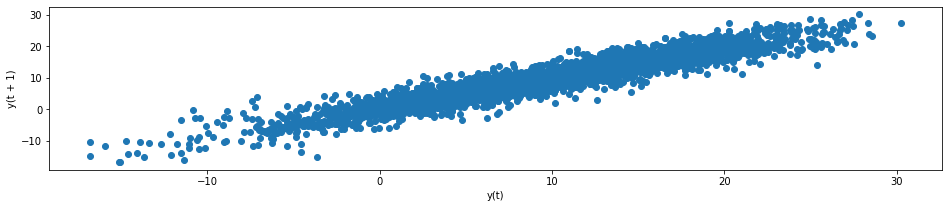

In [9]:
#visual check that we can do to see if there is an autocorrelation in our time series dataset.
lag_plot(data.iloc[:,1])

In [10]:
np.corrcoef(x=data.iloc[:-1,1],y=data.iloc[1:,1]) # Correlated

array([[1.        , 0.94610949],
       [0.94610949, 1.        ]])

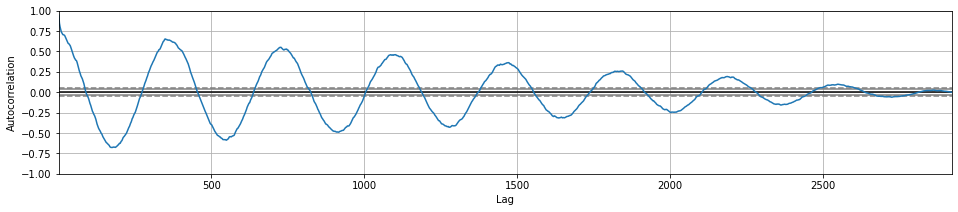

In [11]:
autocorrelation_plot(data.iloc[:,1])


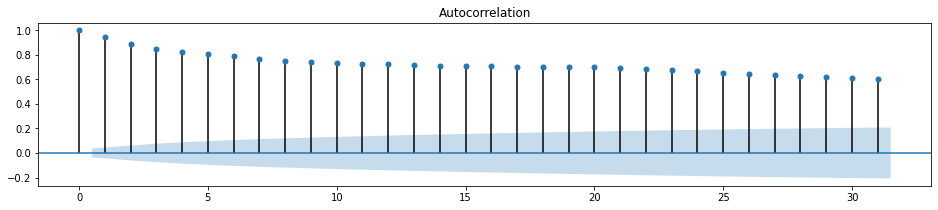

In [12]:
plot_acf(data.iloc[:,1], lags=31)
pyplot.show()

# Splitting The Data

In [13]:
#Splitting The Data
X = data.iloc[:,1].values
size = int(X.shape[0]*.7)
train, test = X[0:size], X[size:]

In [14]:
accuracies = dict()

# AutoReg

In [15]:
# i'll Use Grid Search On Lag Paramter To Get The Best
acc = dict()
for lag in range(10,1001,50):
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    acc[lag] = mean_squared_error(test, predictions,squared=False)

In [16]:
acc

{10: 7.228313481605152,
 60: 7.244634402679157,
 110: 5.28751023293754,
 160: 4.166497941382922,
 210: 4.196658497529369,
 260: 4.166572205445786,
 310: 4.1425134940406,
 360: 4.085195623467647,
 410: 4.550236721489368,
 460: 4.355118407648159,
 510: 4.268829077311113,
 560: 4.325941263293442,
 610: 4.418523948154807,
 660: 5.0814727880678525,
 710: 5.4250915087462355,
 760: 6.137660412075401,
 810: 7.576206642495643,
 860: 8.679926602686118,
 910: 9.426126865881242,
 960: 302.8468619757915}

In [17]:
acc = dict()
for lag in range(160,710,20):
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    acc[lag] = mean_squared_error(test, predictions,squared=False)


In [18]:
acc

{160: 4.166497941382922,
 180: 4.191019936977695,
 200: 4.223298748244851,
 220: 4.2420163548419385,
 240: 4.176499308533675,
 260: 4.166572205445786,
 280: 4.251512955262026,
 300: 4.150761508973033,
 320: 4.138990078528874,
 340: 4.080789190963233,
 360: 4.085195623467647,
 380: 4.160221351059404,
 400: 4.273437021514732,
 420: 4.709317145380528,
 440: 4.321342294637774,
 460: 4.355118407648159,
 480: 4.268119032955828,
 500: 4.317414050081807,
 520: 4.251563970429833,
 540: 4.251562065363695,
 560: 4.325941263293442,
 580: 4.302069915715037,
 600: 4.319717777519763,
 620: 4.466126155739458,
 640: 4.859650702923775,
 660: 5.0814727880678525,
 680: 5.358670347138111,
 700: 5.38756733920095}

In [19]:
acc = dict()
for lag in range(320,400,5):
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    acc[lag] = mean_squared_error(test, predictions,squared=False)


In [20]:
acc

{320: 4.138990078528874,
 325: 4.160950195853497,
 330: 4.161811751582792,
 335: 4.124525076130116,
 340: 4.080789190963233,
 345: 4.053671897222719,
 350: 4.047366722610429,
 355: 4.064513233557223,
 360: 4.085195623467647,
 365: 4.090175764730796,
 370: 4.135440108552159,
 375: 4.173780579667461,
 380: 4.160221351059404,
 385: 4.196717747265156,
 390: 4.225846661449472,
 395: 4.242569591186962}

Test RMSE: 4.047


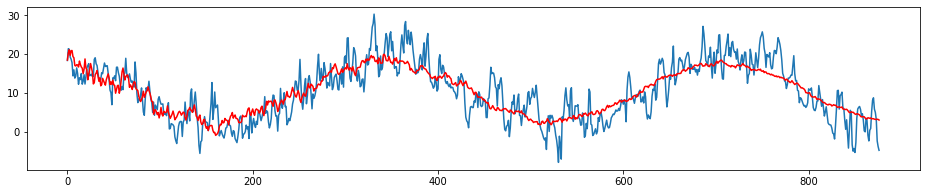

In [21]:
# train autoregression
model = AutoReg(train, lags=350)
model_fit = model.fit()
#print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = mean_squared_error(test, predictions,squared=False)
accuracies['auto_reg'] = rmse
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA

Test RMSE: 2.538


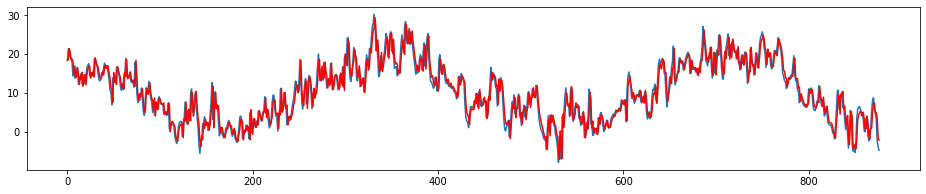

In [22]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
accuracies['arima'] = rmse
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# FbProphet

In [43]:
#Preparing The Same Data For FbProphet
#Splitting The Data
size = int(data.shape[0]*.7)
train_fb, test_fb = data[0:size], data[size:]

In [47]:
train_fb.columns = ['ds', 'y']
test_fb.columns = ['ds', 'y']
train_fb.head()

,ds,y
0,2009-01-01,-6.870
1,2009-01-02,-3.930
2,2009-01-03,-5.175
3,2009-01-04,-1.440
4,2009-01-05,-3.640


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test RMSE: 4.410


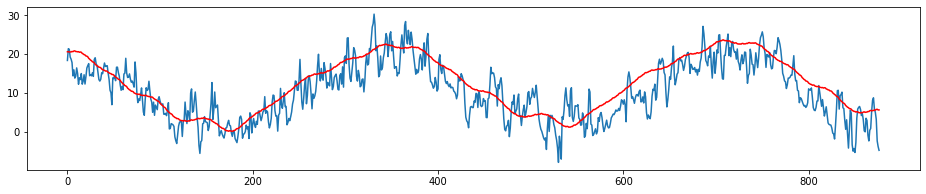

In [55]:
#Base Model
m = Prophet()
#Fitting The Model
m.fit(train_fb)
#Testing On Test Data
preds = m.predict(test_fb)
y_preds = preds['yhat'].values
y_true = test_fb['y'].values
#Calculate RMSE
rmse = mean_squared_error(y_true, y_preds,squared=False)
#Plotting
accuracies['fbprophet'] = rmse
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(y_true)
pyplot.plot(y_preds, color='red')
pyplot.show()

**Using Grid Search**

In [51]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

rmses = []


for param in params:
    m = Prophet(**param)
    m.fit(train_fb)
    
    df_cv = cross_validation(model=m,horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['rmse'] = rmses

best_params = params[np.argmin(rmses)]

print(best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2012-02-05 12:00:00 and 2013-08-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


In [52]:
# Fit The Best 
m = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=10
)
#Fitting The Model
m.fit(train_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test RMSE: 3.924


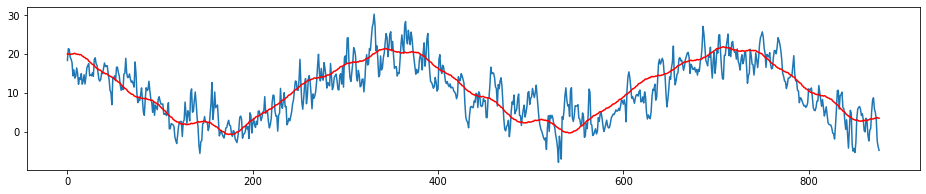

In [54]:
#Testing On Test Data
preds = m.predict(test_fb)
y_preds = preds['yhat'].values
y_true = test_fb['y'].values
#Calculate RMSE
rmse = mean_squared_error(y_true, y_preds,squared=False)
#Plotting
accuracies['fbprophet_tuned'] = rmse
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(y_true)
pyplot.plot(y_preds, color='red')
pyplot.show()

# Deep Learning Approachs

In [59]:
max_features = 1
n_steps = 10
batch_size = 1
filters = 50
kernel_size = 2
hidden_dims = 250
epochs = 40

In [60]:
#Preparing The Data 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# Training
X_train,y_train = split_sequence(train,n_steps)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],max_features))

In [62]:
# Testing 
X_test,y_test = split_sequence(test,n_steps)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],max_features))

## CONV1D

In [63]:
model = Sequential()
# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,
                 input_shape=(n_steps,max_features)))
# we use max pooling:
model.add(MaxPooling1D(pool_size=8))

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 50)             150       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 50)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 250)            12750     
_________________________________________________________________
dropout (Dropout)            (None, 1, 250)            0         
_________________________________________________________________
activation (Activation)      (None, 1, 250)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              251       
Total params: 13,151
Trainable params: 13,151
Non-trainable params: 0
____________________________________________________

In [64]:
model.compile(optimizer='adam', loss = 'mse')

In [65]:
model.fit(X_train,y_train,epochs=epochs,batch_size = batch_size)

Epoch 1/40
2034/2034 [==============================] - 37s 3ms/step - loss: 19.3601
Epoch 2/40
2034/2034 [==============================] - 6s 3ms/step - loss: 17.5068
Epoch 3/40
2034/2034 [==============================] - 6s 3ms/step - loss: 17.3300
Epoch 4/40
2034/2034 [==============================] - 6s 3ms/step - loss: 17.0814
Epoch 5/40
2034/2034 [==============================] - 5s 3ms/step - loss: 16.7203
Epoch 6/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.2185
Epoch 7/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.6111
Epoch 8/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.4413
Epoch 9/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.1847
Epoch 10/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.1610
Epoch 11/40
2034/2034 [==============================] - 6s 3ms/step - loss: 16.4312
Epoch 12/40
2034/2034 [==============================] - 6s 3ms/step - lo

In [66]:
# Predict
y_hat = model.predict(X_test)

In [67]:
y_test.shape, y_hat.shape ,X_test.shape

((867,), (867, 1, 1), (867, 10, 1))

In [68]:
# evaluate forecasts
rmse = mean_squared_error(y_test, y_hat.squeeze(),squared=False)
accuracies['conv1d'] = rmse
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.106


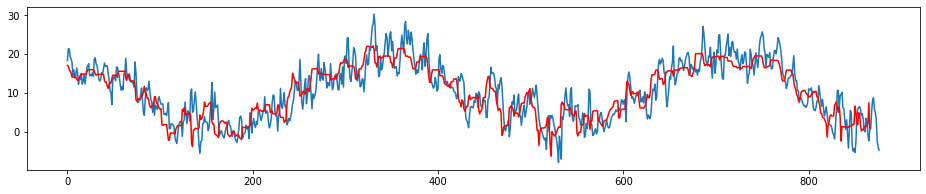

In [69]:
# plot forecasts agaist actual outcomes
pyplot.plot(test)
pyplot.plot(y_hat.squeeze(), color='red')
pyplot.show()

## LSTM

In [70]:
print('Build model...')
model = Sequential()
model.add(Input(shape=(n_steps,max_features)))
model.add(LSTM(64,return_sequences=True,))
model.add((LSTM(32,return_sequences=True)))
model.add(LSTM(16))
model.add(Dense(1))

model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(optimizer='adam', loss = 'mse')

In [72]:
model.fit(X_train,y_train,epochs=epochs,batch_size = batch_size)

Epoch 1/40
2034/2034 [==============================] - 21s 8ms/step - loss: 27.2893
Epoch 2/40
2034/2034 [==============================] - 16s 8ms/step - loss: 8.4174
Epoch 3/40
2034/2034 [==============================] - 16s 8ms/step - loss: 7.2766
Epoch 4/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.9700
Epoch 5/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.7780
Epoch 6/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.6514
Epoch 7/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.6084
Epoch 8/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.5178
Epoch 9/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.4272
Epoch 10/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.4019
Epoch 11/40
2034/2034 [==============================] - 16s 8ms/step - loss: 6.1529
Epoch 12/40
2034/2034 [==============================] - 16s 8ms/step - l

In [73]:
y_hat = model.predict(X_test)

In [74]:
y_test.shape, y_hat.shape ,X_test.shape

((867,), (867, 1), (867, 10, 1))

In [75]:
# evaluate forecasts
rmse =mean_squared_error(y_test, y_hat.squeeze(),squared = False)
accuracies['lstm'] = rmse


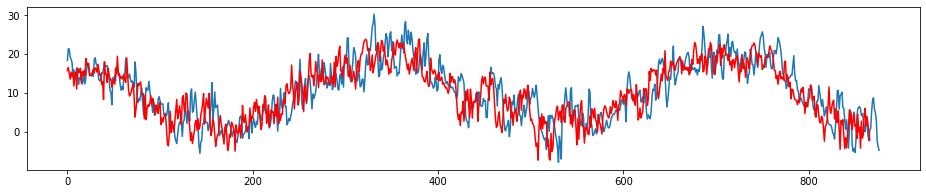

In [76]:
# plot forecasts agaist actual outcomes
pyplot.plot(test)
pyplot.plot(y_hat.squeeze(), color='red')
pyplot.show()

# LSTM + CONV1D

In [77]:
model = Sequential()

model.add(Input(shape=(n_steps,max_features)))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(32))
model.add(Dense(1))



model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 50)             150       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 10,807
Trainable params: 10,807
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(optimizer='adam', loss = 'mse')

In [79]:
model.fit(X_train,y_train,epochs=epochs,batch_size = batch_size)

Epoch 1/40
2034/2034 [==============================] - 10s 4ms/step - loss: 24.7933
Epoch 2/40
2034/2034 [==============================] - 8s 4ms/step - loss: 14.8863
Epoch 3/40
2034/2034 [==============================] - 8s 4ms/step - loss: 14.4559
Epoch 4/40
2034/2034 [==============================] - 8s 4ms/step - loss: 14.0893
Epoch 5/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.8440
Epoch 6/40
2034/2034 [==============================] - 8s 4ms/step - loss: 14.1150
Epoch 7/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.6018
Epoch 8/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.6616
Epoch 9/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.4961
Epoch 10/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.3315
Epoch 11/40
2034/2034 [==============================] - 8s 4ms/step - loss: 13.2835
Epoch 12/40
2034/2034 [==============================] - 8s 4ms/step - lo

In [80]:
y_hat = model.predict(X_test)

In [81]:
y_test.shape, y_hat.shape ,X_test.shape

((867,), (867, 1), (867, 10, 1))

In [82]:
# evaluate forecasts
rmse =mean_squared_error(y_test, y_hat.squeeze(),squared = False)
accuracies['lstm_conv1d'] = rmse


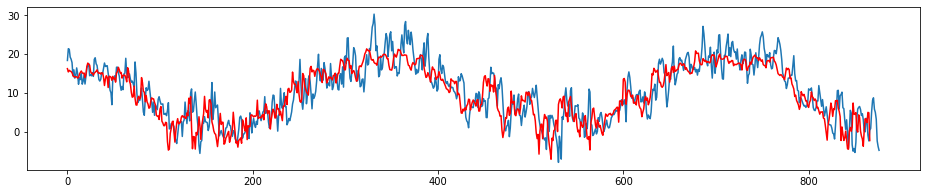

In [83]:
# plot forecasts agaist actual outcomes
pyplot.plot(test)
pyplot.plot(y_hat.squeeze(), color='red')
pyplot.show()

# Try AutoTuner

In [84]:
def model_builder(hp):
    '''
    Builds the model and sets up the hyperparameters to tune.

    Args:
    hp - Keras tuner object

    Returns:
    model with hyperparameters to tune
    '''
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)

    model = Sequential()
    model.add(Input(shape=(n_steps,max_features)))
    model.add(LSTM(hp_units1,return_sequences=True,))
    model.add((LSTM(hp_units2,return_sequences=True)))
    model.add(LSTM(8))
    model.add(Dense(1))


    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

In [85]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=15,
                     factor=3,
                     directory='kt_dir',
                     project_name='kt_hyperband')

In [86]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [87]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [88]:
# Perform hypertuning
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[stop_early])

Trial 30 Complete [00h 00m 26s]
val_mean_squared_error: 38.004844665527344

Best val_mean_squared_error So Far: 7.430581092834473
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [89]:
best_hps=tuner.get_best_hyperparameters()[0]



In [90]:
best_hps.values

{'learning_rate': 0.01,
 'tuner/bracket': 0,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units1': 64,
 'units2': 272}

In [91]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 272)           366656    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 8992      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 392,553
Trainable params: 392,553
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Train the hypertuned model
h_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/40
64/64 [==============================] - 6s 15ms/step - loss: 72.8869 - mean_squared_error: 72.8869
Epoch 2/40
64/64 [==============================] - 1s 15ms/step - loss: 30.4728 - mean_squared_error: 30.4728
Epoch 3/40
64/64 [==============================] - 1s 15ms/step - loss: 15.6166 - mean_squared_error: 15.6166
Epoch 4/40
64/64 [==============================] - 1s 14ms/step - loss: 11.6196 - mean_squared_error: 11.6196
Epoch 5/40
64/64 [==============================] - 1s 15ms/step - loss: 9.6582 - mean_squared_error: 9.6582
Epoch 6/40
64/64 [==============================] - 1s 15ms/step - loss: 8.8094 - mean_squared_error: 8.8094
Epoch 7/40
64/64 [==============================] - 1s 15ms/step - loss: 8.1564 - mean_squared_error: 8.1564
Epoch 8/40
64/64 [==============================] - 1s 15ms/step - loss: 7.4876 - mean_squared_error: 7.4876
Epoch 9/40
64/64 [==============================] - 1s 15ms/step - loss: 7.3092 - mean_squared_error: 7.3092
Epoch 10/40

In [93]:
# Evaluate the hypertuned model against the test set
h_eval_dict = h_model.evaluate(X_test, y_test, return_dict=True)

28/28 [==============================] - 1s 6ms/step - loss: 7.9539 - mean_squared_error: 7.9539


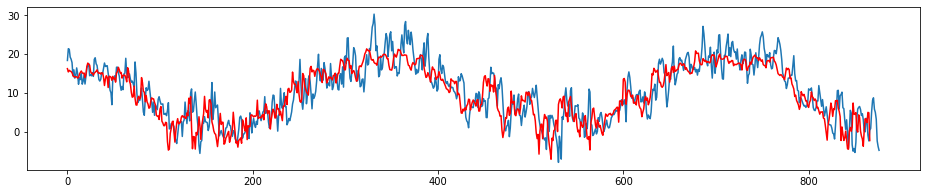

In [94]:
y_hat = model.predict(X_test)
y_test.shape, y_hat.shape ,X_test.shape
# evaluate forecasts
rmse =mean_squared_error(y_test, y_hat.squeeze(),squared = False)
accuracies['lstm_tuned'] = rmse

# plot forecasts agaist actual outcomes
pyplot.plot(test)
pyplot.plot(y_hat.squeeze(), color='red')
pyplot.show()

In [95]:
rmse

3.9906103894457168

In [96]:
accuracies

{'arima': 2.5375380349342254,
 'auto_reg': 4.047366722610429,
 'conv1d': 4.105524466980857,
 'fbprophet': 4.409903088176537,
 'fbprophet_tuned': 3.9237724093523028,
 'lstm': 2.792363319378949,
 'lstm_conv1d': 3.9906103894457168,
 'lstm_tuned': 3.9906103894457168}

# **Plotting The Results**

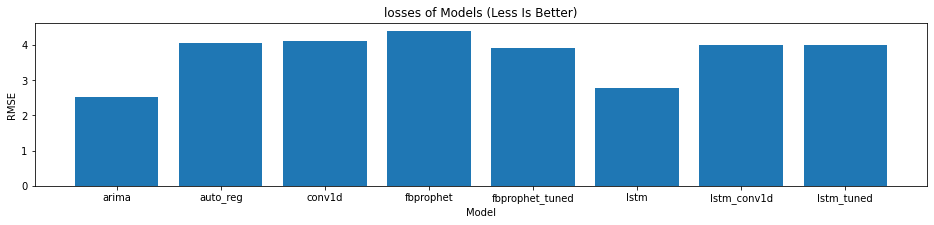

In [109]:
lists = sorted(accuracies.items()) 
k, v = zip(*lists) # unpack a list of pairs into two tuples
plt.bar(k, v)
plt.title('losses of Models (Less Is Better)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()